# Chapter 7 - Distributional Q-learning
- added cnn version and compared performance
- added variance-aware policy
- TODO: add video recording to clearly show the performance difference apart from just the losses
- TODO: compare performance to "vanilla" non-distributional DQN
- TODO: add multiple frames per state and compare performance
- TODO: extend to quantile regression and compare performance

Implemented here: "C51" from "A Distributional Perspective on Reinforcement Learning" https://arxiv.org/pdf/1707.06887.pdf

TODO: Implement "Distributional Reinforcement Learning with Quantile Regression" https://arxiv.org/abs/1710.10044

In [1]:
import copy
from collections import deque
from random import shuffle

import numpy as np
import gym
import torch
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import trange
from einops import rearrange
from skimage.transform import resize

In [2]:
probs = np.array([0.6, 0.1, 0.1, 0.1, 0.1])
outcomes = np.array([18, 21, 17, 17, 21])
expected_value = 0.0
for i in range(probs.shape[0]):
    expected_value += probs[i] * outcomes[i]

print(expected_value)

18.4


In [3]:
expected_value = probs @ outcomes
print(expected_value)

18.4


In [4]:
t0 = 18.4
T = lambda: t0 + np.random.randn(1)
T()

array([19.1218387])

##### Listing 7.1

<BarContainer object of 51 artists>

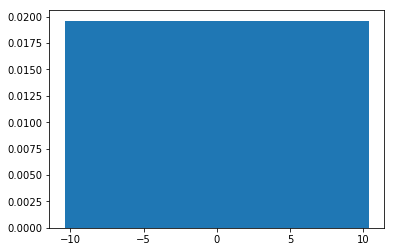

In [5]:
vmin,vmax = -10.,10. #A
nsup=51 #B
support = np.linspace(vmin,vmax,nsup) #C
probs = np.ones(nsup)
probs /= probs.sum()
z3 = torch.from_numpy(probs).float()
plt.bar(support,probs) #D

##### Listing 7.2

In [6]:
def update_dist(r,support,probs,lim=(-10.,10.),gamma=0.8):
    nsup = probs.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.) #A
    bj = np.round((r-vmin)/dz) #B
    bj = int(np.clip(bj,0,nsup-1)) #C
    m = probs.clone()
    j = 1
    for i in range(bj,1,-1): #D
        m[i] += np.power(gamma,j) * m[i-1]
        j += 1
    j = 1
    for i in range(bj,nsup-1,1): #E
        m[i] += np.power(gamma,j) * m[i+1]
        j += 1
    m /= m.sum() #F
    return m

In [7]:
probs

array([0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784, 0.01960784, 0.01960784, 0.01960784, 0.01960784,
       0.01960784])

##### Listing 7.3

<BarContainer object of 51 artists>

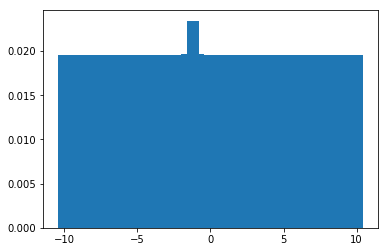

In [8]:
ob_reward = -1
Z = torch.from_numpy(probs).float()
Z = update_dist(ob_reward,torch.from_numpy(support).float(),Z,lim=(vmin,vmax),gamma=0.1)
plt.bar(support,Z)

##### Listing 7.4

<BarContainer object of 51 artists>

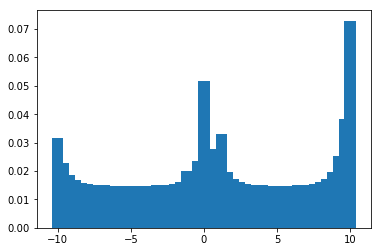

In [9]:
ob_rewards = [10,10,10,0,1,0,-10,-10,10,10]
for i in range(len(ob_rewards)):
    Z = update_dist(ob_rewards[i], torch.from_numpy(support).float(), Z, lim=(vmin,vmax), gamma=0.5)
plt.bar(support, Z)

##### Listing 7.5

<BarContainer object of 51 artists>

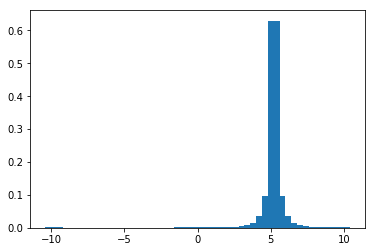

In [10]:
ob_rewards = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
for i in range(len(ob_rewards)):
    Z = update_dist(ob_rewards[i], torch.from_numpy(support).float(), \
    Z, lim=(vmin,vmax), gamma=0.7)
plt.bar(support, Z)

##### Listing 7.6

In [11]:
# This network is defined with a single parameter vector theta that gets reshaped and then 
def dist_dqn(x,theta,aspace=3):#A
    dim0,dim1,dim2,dim3 = 128,100,25,51 #B
    t1 = dim0*dim1
    t2 = dim2*dim1
    theta1 = theta[0:t1].reshape(dim0,dim1) #C
    theta2 = theta[t1:t1 + t2].reshape(dim1,dim2)
    l1 = x @ theta1 #D
    l1 = torch.selu(l1)
    l2 = l1 @ theta2 #E
    l2 = torch.selu(l2)
    l3 = []
    for i in range(aspace): #F
        step = dim2*dim3
        theta5_dim = t1 + t2 + i * step
        theta5 = theta[theta5_dim:theta5_dim+step].reshape(dim2,dim3)
        l3_ = l2 @ theta5 #G
        l3.append(l3_)
    l3 = torch.stack(l3,dim=1) #H
    l3 = torch.nn.functional.softmax(l3,dim=2)
    return l3.squeeze()

##### Listing 7.7

In [12]:
def get_target_dist(dist_batch,action_batch,reward_batch,support,lim=(-10,10),gamma=0.8):
    nsup = support.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    target_dist_batch = dist_batch.clone()
    for i in range(dist_batch.shape[0]): #A
        dist_full = dist_batch[i]
        action = int(action_batch[i].item())
        dist = dist_full[action]
        r = reward_batch[i]
        if r != -1: #B
            target_dist = torch.zeros(nsup)
            bj = np.round((r-vmin)/dz)
            bj = int(np.clip(bj,0,nsup-1))
            target_dist[bj] = 1.
        else: #C
            target_dist = update_dist(r,support,dist,lim=lim,gamma=gamma)
        target_dist_batch[i,action,:] = target_dist #D
        
    return target_dist_batch

##### Listing 7.8

In [13]:
# cross-entry loss between predicted and target distributions
def lossfn(x,y):#A
    loss = torch.Tensor([0.])
    loss.requires_grad=True
    for i in range(x.shape[0]): #B 
        loss_ = -1 *  torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0) #C
        loss = loss + loss_
    return loss

##### Listing 7.9

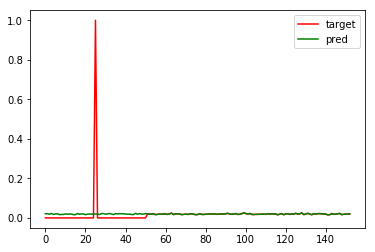

In [24]:
aspace = 3 #A
tot_params = 128*100 + 25*100 + aspace*25*51 #B
theta = torch.randn(tot_params)/10. #C
theta.requires_grad=True
theta_2 = theta.detach().clone() #D
#
vmin,vmax= -10,10
gamma=0.9
lr = 0.00001
update_rate = 75 #E
support = torch.linspace(-10,10,51)
state = torch.randn(2,128)/10. #F
action_batch = torch.Tensor([0,2]) #G
reward_batch = torch.Tensor([0,10]) #H
losses = [] 
pred_batch = dist_dqn(state,theta,aspace=aspace) #I
target_dist = get_target_dist(pred_batch,action_batch,reward_batch, \
                                 support, lim=(vmin,vmax),gamma=gamma) #J

plt.plot((target_dist.flatten(start_dim=1)[0].data.numpy()),color='red',label='target')
plt.plot((pred_batch.flatten(start_dim=1)[0].data.numpy()),color='green',label='pred')
plt.legend()

##### Listing 7.10

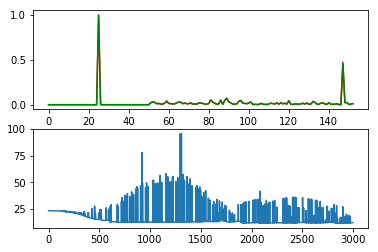

In [28]:
for i in range(1000):
    reward_batch = torch.Tensor([0,8]) + torch.randn(2)/10.0 #A
    pred_batch = dist_dqn(state,theta,aspace=aspace) #B
    pred_batch2 = dist_dqn(state,theta_2,aspace=aspace) #C
    target_dist = get_target_dist(pred_batch2,action_batch,reward_batch, \
                                 support, lim=(vmin,vmax),gamma=gamma) #D
    loss = lossfn(pred_batch,target_dist.detach()) #E
    losses.append(loss.item())
    loss.backward()
    # Gradient Descent
    with torch.no_grad():
        theta -= lr * theta.grad
    theta.requires_grad = True
    
    if i % update_rate == 0: #F 
        theta_2 = theta.detach().clone()

fig,ax = plt.subplots(2,1)
ax[0].plot((target_dist.flatten(start_dim=1)[0].data.numpy()),color='red',label='target')
ax[0].plot((pred_batch.flatten(start_dim=1)[0].data.numpy()),color='green',label='pred')
ax[1].plot(losses)

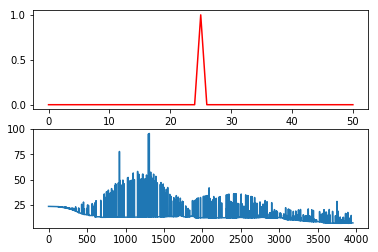

In [29]:
update_rate = 1
for i in range(1000):
    reward_batch = torch.Tensor([0,8]) + torch.randn(2)/10.0 #A
    pred_batch = dist_dqn(state,theta,aspace=aspace) #B
    pred_batch2 = dist_dqn(state,theta_2,aspace=aspace) #C
    target_dist = get_target_dist(pred_batch2,action_batch,reward_batch, \
                                 support, lim=(vmin,vmax),gamma=gamma) #D
    loss = lossfn(pred_batch,target_dist.detach()) #E
    losses.append(loss.item())
    loss.backward()
    # Gradient Descent
    with torch.no_grad():
        theta -= lr * theta.grad
    theta.requires_grad = True
    
    if i % update_rate == 0: #F 
        theta_2 = theta.detach().clone()

fig,ax = plt.subplots(2,1)
ax[0].plot((target_dist.flatten(start_dim=1)[0].data.numpy()),color='red',label='target')
ax[0].plot((pred_batch.flatten(start_dim=1)[0].data.numpy()),color='green',label='pred')
ax[1].plot(losses)

##### Listing 7.11

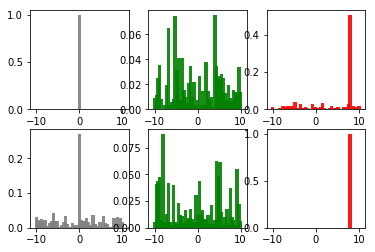

In [26]:
tpred = pred_batch
cs = ['gray','green','red']
num_batch = 2
labels = ['Action {}'.format(i,) for i in range(aspace)]
fig,ax = plt.subplots(nrows=num_batch,ncols=aspace)

for j in range(num_batch): #A 
    for i in range(tpred.shape[1]): #B
        ax[j,i].bar(support.data.numpy(),tpred[j,i,:].data.numpy(),\
                label='Action {}'.format(i),alpha=0.9,color=cs[i])

##### Listing 7.12

In [17]:
def preproc_state(state):
    p_state = torch.from_numpy(state).unsqueeze(dim=0).float()
    p_state = torch.nn.functional.normalize(p_state,dim=1) #A
    return p_state

def get_action(dist,support):
    actions = []
    for b in range(dist.shape[0]): #B
        expectations = [support @ dist[b,a,:] for a in range(dist.shape[1])] #C
        action = int(np.argmax(expectations)) #D
        actions.append(action)
    actions = torch.Tensor(actions).int()
    return actions

##### Listing 7.13

In [18]:
env = gym.make('Freeway-ram-v0') # for this to work you'll need to get the atari rom
aspace = 3
env.env.get_action_meanings()

vmin,vmax = -10,10
replay_size = 200
batch_size = 50
nsup = 51
dz = (vmax - vmin) / (nsup-1)
support = torch.linspace(vmin,vmax,nsup)

replay = deque(maxlen=replay_size) #A
lr = 0.0001 #B 
gamma = 0.1 #C 
epochs = 1300
eps = 0.20 #D starting epsilon for epsilon-greedy policy
eps_min = 0.05 #E ending epsilon
priority_level = 5 #F 
update_freq = 25 #G 

#Initialize DQN parameter vector
tot_params = 128*100 + 25*100 + aspace*25*51  #H 
theta = torch.randn(tot_params)/10. #I 
theta.requires_grad=True
theta_2 = theta.detach().clone() #J 

losses = []
cum_rewards = [] #K 
renders = []
state = preproc_state(env.reset())

##### Listing 7.14

In [19]:
for i in trange(epochs):
    pred = dist_dqn(state,theta,aspace=aspace)
    if i < replay_size or np.random.rand(1) < eps: #A
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.unsqueeze(dim=0).detach(),support).item()
    state2, reward, done, info = env.step(action) #B
    state2 = preproc_state(state2)
    if reward == 1: cum_rewards.append(1) 
    reward = 10 if reward == 1 else reward #C
    reward = -10 if done else reward #D
    reward = -1 if reward == 0 else reward #E
    exp = (state,action,reward,state2) #F
    replay.append(exp) #G
    
    if reward == 10: #H
        for e in range(priority_level):
            replay.append(exp)
            
    shuffle(replay)
    state = state2

    if len(replay) == replay_size: #I
        indx = np.random.randint(low=0,high=len(replay),size=batch_size)
        exps = [replay[j] for j in indx]
        state_batch = torch.stack([ex[0] for ex in exps],dim=1).squeeze()
        action_batch = torch.Tensor([ex[1] for ex in exps])
        reward_batch = torch.Tensor([ex[2] for ex in exps])
        state2_batch = torch.stack([ex[3] for ex in exps],dim=1).squeeze()
        pred_batch = dist_dqn(state_batch.detach(),theta,aspace=aspace)
        pred2_batch = dist_dqn(state2_batch.detach(),theta_2,aspace=aspace)
        target_dist = get_target_dist(pred2_batch,action_batch,reward_batch, \
                                     support, lim=(vmin,vmax),gamma=gamma)
        loss = lossfn(pred_batch,target_dist.detach())
        losses.append(loss.item())
        loss.backward()
        with torch.no_grad(): #J
            theta -= lr * theta.grad
        theta.requires_grad = True
        
    if i % update_freq == 0: #K
        theta_2 = theta.detach().clone()
        
    if i > 100 and eps > eps_min: #L
        dec = 1./np.log2(i)
        dec /= 1e3
        eps -= dec
    
    if done: #M
        state = preproc_state(env.reset())
        done = False

  0%|          | 0/1300 [00:00<?, ?it/s]

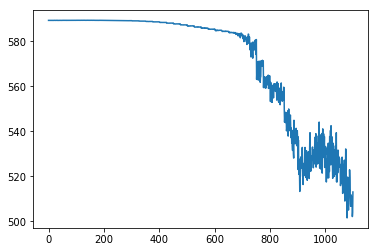

In [20]:
# original network
plt.plot(losses)

## Rebuild DQN with standard PyTorch

In [90]:
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
model = torch.nn.Sequential(
    torch.nn.Linear(128,100),
    torch.nn.SELU(),
    torch.nn.Linear(100,25),
    torch.nn.SELU(),
    torch.nn.Linear(25,51),
    torch.nn.SELU(),
    torch.nn.Linear(51,51*3),
    Reshape(-1, 3, 51), # dim 2 needs to match nsup. # batch, aspace, nsup
    # this is done this way so that you can create a distribution of values for each action
    torch.nn.Softmax(dim=2),
)
 
model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [96]:
# cross-entry loss between predicted and target distributions
def lossfn(x,y):#A
    loss = torch.Tensor([0.])
    loss.requires_grad=True
    for i in range(x.shape[0]): #B 
        loss_ = -1 *  torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0) #C
        loss = loss + loss_
    return loss

def update_dist(r,support,probs,lim=(-10.,10.),gamma=0.8):
#     print('probs', probs)
    nsup = probs.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.) #A
    bj = np.round((r-vmin)/dz) #B
    bj = int(np.clip(bj,0,nsup-1)) #C
    m = probs.clone()
    j = 1
    for i in range(bj,1,-1): #D
        m[i] += np.power(gamma,j) * m[i-1]
        j += 1
    j = 1
    for i in range(bj,nsup-1,1): #E
        m[i] += np.power(gamma,j) * m[i+1]
        j += 1
    m /= m.sum() #F
    return m

def get_target_dist(dist_batch,action_batch,reward_batch,support,lim=(-10,10),gamma=0.8):
    nsup = support.shape[0]
#     print('nsup',nsup)
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    target_dist_batch = dist_batch.clone()
    for i in range(dist_batch.shape[0]): #A
        dist_full = dist_batch[i]
        action = int(action_batch[i].item())
        dist = dist_full[action]
        r = reward_batch[i]
        if r != -1: #B
            target_dist = torch.zeros(nsup)
            bj = np.round((r-vmin)/dz)
            bj = int(np.clip(bj,0,nsup-1))
            target_dist[bj] = 1.
        else: #C
            target_dist = update_dist(r,support,dist,lim=lim,gamma=gamma)
        target_dist_batch[i,action,:] = target_dist #D
        
    return target_dist_batch

def preproc_state(state):
    p_state = torch.from_numpy(state).unsqueeze(dim=0).float()
    p_state = torch.nn.functional.normalize(p_state,dim=1) #A
    return p_state

def get_action(dist,support):
    actions = []
    for b in range(dist.shape[0]): #B
#         print(dist.shape)
#         print(support.shape)
        expectations = [support @ dist[b,a,:] for a in range(dist.shape[1])] #C
#         print(expectations)
        action = int(np.argmax(expectations)) #D
        actions.append(action)
    actions = torch.Tensor(actions).int()
    return actions

In [97]:
env = gym.make('Freeway-ram-v0') # for this to work you'll need to get the atari rom
aspace = 3
env.env.get_action_meanings()

vmin,vmax = -10,10
replay_size = 200
batch_size = 50
nsup = 51
dz = (vmax - vmin) / (nsup-1)
support = torch.linspace(vmin,vmax,nsup)

replay = deque(maxlen=replay_size) #A
lr = 0.0001 #B 
gamma = 0.1 #C 
epochs = 1300
eps = 0.20 #D starting epsilon for epsilon-greedy policy
eps_min = 0.05 #E ending epsilon
priority_level = 5 #F 
update_freq = 25 #G 

losses = []
cum_rewards = [] #K 
renders = []
state = preproc_state(env.reset())

In [98]:
for i in trange(epochs):
#     print(state.shape)
    pred = model(state)
#     print(pred.shape)
    if i < replay_size or np.random.rand(1) < eps: #A
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.detach(),support).item()
    state2, reward, done, info = env.step(action) #B
    state2 = preproc_state(state2)
    if reward == 1: cum_rewards.append(1) 
    reward = 10 if reward == 1 else reward #C
    reward = -10 if done else reward #D
    reward = -1 if reward == 0 else reward #E
    exp = (state,action,reward,state2) #F
    replay.append(exp) #G
    
    if reward == 10: #H
        for e in range(priority_level):
            replay.append(exp)
            
    shuffle(replay)
    state = state2

    if len(replay) == replay_size: #I
        indx = np.random.randint(low=0,high=len(replay),size=batch_size)
        exps = [replay[j] for j in indx]
        state_batch = torch.stack([ex[0] for ex in exps],dim=1).squeeze()
        action_batch = torch.Tensor([ex[1] for ex in exps])
        reward_batch = torch.Tensor([ex[2] for ex in exps])
        state2_batch = torch.stack([ex[3] for ex in exps],dim=1).squeeze()  
        
        pred_batch = model(state_batch.detach())
        pred2_batch = model2(state2_batch.detach())

        target_dist = get_target_dist(pred2_batch,action_batch,reward_batch, 
                                      support, lim=(vmin,vmax),gamma=gamma)
        loss = lossfn(pred_batch,target_dist.detach())
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    
    if i % update_freq == 0:
        model2.load_state_dict(model.state_dict())
        
    if i > 100 and eps > eps_min: #L
        dec = 1./np.log2(i)
        dec /= 1e3
        eps -= dec
    
    if done: #M
        state = preproc_state(env.reset())
        done = False

  0%|          | 0/1300 [00:00<?, ?it/s]

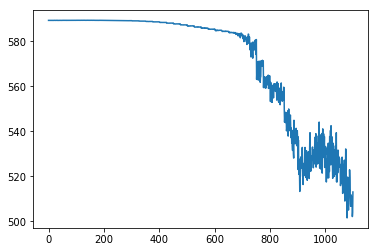

In [20]:
# original network
plt.plot(losses)

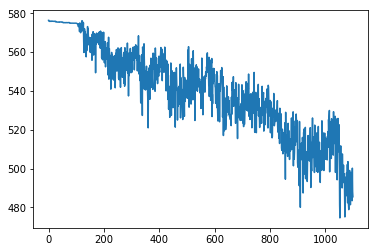

In [99]:
# refactored network
plt.plot(losses)

## Rebuild DQN with CNN

In [180]:
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
model = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding='same'),
        torch.nn.SELU(),
        torch.nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding='same'),
        torch.nn.SELU(),
        torch.nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding='same'),
        torch.nn.SELU(),
        torch.nn.Conv2d(32, 51*3, kernel_size=(3, 3), stride=1, padding='same'),
        torch.nn.SELU(),
        torch.nn.AdaptiveAvgPool2d((1)),
        torch.nn.Flatten(start_dim=1),
        torch.nn.ReLU(),
        Reshape(-1, 3, 51), # dim 2 needs to match nsup. # batch, aspace, nsup
        # this is done this way so that you can create a distribution of values for each action
        torch.nn.Softmax(dim=2),
)
 
model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [181]:
# cross-entry loss between predicted and target distributions
def lossfn(x,y):#A
    loss = torch.Tensor([0.])
    loss.requires_grad=True
    for i in range(x.shape[0]): #B 
        loss_ = -1 *  torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0) #C
        loss = loss + loss_
    return loss

def update_dist(r,support,probs,lim=(-10.,10.),gamma=0.8):
#     print('probs', probs)
    nsup = probs.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.) #A
    bj = np.round((r-vmin)/dz) #B
    bj = int(np.clip(bj,0,nsup-1)) #C
    m = probs.clone()
    j = 1
    for i in range(bj,1,-1): #D
        m[i] += np.power(gamma,j) * m[i-1]
        j += 1
    j = 1
    for i in range(bj,nsup-1,1): #E
        m[i] += np.power(gamma,j) * m[i+1]
        j += 1
    m /= m.sum() #F
    return m

def get_target_dist(dist_batch,action_batch,reward_batch,support,lim=(-10,10),gamma=0.8):
    nsup = support.shape[0]
#     print('nsup',nsup)
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    target_dist_batch = dist_batch.clone()
    for i in range(dist_batch.shape[0]): #A
        dist_full = dist_batch[i]
        action = int(action_batch[i].item())
        dist = dist_full[action]
        r = reward_batch[i]
        if r != -1: #B
            target_dist = torch.zeros(nsup)
            bj = np.round((r-vmin)/dz)
            bj = int(np.clip(bj,0,nsup-1))
            target_dist[bj] = 1.
        else: #C
            target_dist = update_dist(r,support,dist,lim=lim,gamma=gamma)
        target_dist_batch[i,action,:] = target_dist #D
        
    return target_dist_batch

def preproc_state(state):
#     p_state = torch.from_numpy(state).float()
    p_state = torch.from_numpy(downscale_obs(state, to_gray=False)).unsqueeze(dim=0).float()
#     p_state = torch.from_numpy(state).unsqueeze(dim=0).float()
    p_state = torch.nn.functional.normalize(p_state) #A
    p_state = rearrange(p_state, 'b h w c -> b c h w')
    return p_state

# Listing 8.2
def downscale_obs(obs, new_size=(42, 42), to_gray=True):
    if to_gray:
        return resize(obs, new_size, anti_aliasing=True).max(axis=2)  # B
    else:
        return resize(obs, new_size, anti_aliasing=True)
    
# Listing 8.4
def prepare_state(state):  # A
    return torch.from_numpy(downscale_obs(state, to_gray=True)).float().unsqueeze(dim=0)

def get_action(dist,support):
    actions = []
    for b in range(dist.shape[0]): #B
#         print(dist.shape)
#         print(support.shape)
        expectations = [support @ dist[b,a,:] for a in range(dist.shape[1])] #C
#         print(expectations)
        action = int(np.argmax(expectations)) #D
        actions.append(action)
    actions = torch.Tensor(actions).int()
    return actions

In [182]:
# load screen version of Freeway
env = gym.make('Freeway-v0') # for this to work you'll need to get the atari rom
aspace = 3
env.env.get_action_meanings()

vmin,vmax = -10,10
replay_size = 200
batch_size = 50
nsup = 51
dz = (vmax - vmin) / (nsup-1)
support = torch.linspace(vmin,vmax,nsup)

replay = deque(maxlen=replay_size) #A
lr = 0.0001 #B 
gamma = 0.1 #C 
epochs = 1300
eps = 0.20 #D starting epsilon for epsilon-greedy policy
eps_min = 0.05 #E ending epsilon
priority_level = 5 #F 
update_freq = 25 #G 

losses = []
cum_rewards = [] #K 
renders = []
state = preproc_state(env.reset())

In [183]:
for i in trange(epochs):
#     print(state.shape)
    pred = model(state)
#     print(pred.shape)
    if i < replay_size or np.random.rand(1) < eps: #A
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.detach(),support).item()
    state2, reward, done, info = env.step(action) #B
    state2 = preproc_state(state2)
    if reward == 1: cum_rewards.append(1) 
    reward = 10 if reward == 1 else reward #C
    reward = -10 if done else reward #D
    reward = -1 if reward == 0 else reward #E
    exp = (state,action,reward,state2) #F
    replay.append(exp) #G
    
    if reward == 10: #H
        for e in range(priority_level):
            replay.append(exp)
            
    shuffle(replay)
    state = state2

    if len(replay) == replay_size: #I
        indx = np.random.randint(low=0,high=len(replay),size=batch_size)
        exps = [replay[j] for j in indx]
        state_batch = torch.stack([ex[0] for ex in exps],dim=1).squeeze()
        action_batch = torch.Tensor([ex[1] for ex in exps])
        reward_batch = torch.Tensor([ex[2] for ex in exps])
        state2_batch = torch.stack([ex[3] for ex in exps],dim=1).squeeze()  
        
        pred_batch = model(state_batch.detach())
        pred2_batch = model2(state2_batch.detach())

        target_dist = get_target_dist(pred2_batch,action_batch,reward_batch, 
                                      support, lim=(vmin,vmax),gamma=gamma)
        loss = lossfn(pred_batch,target_dist.detach())
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    
    if i % update_freq == 0:
        model2.load_state_dict(model.state_dict())
        
    if i > 100 and eps > eps_min: #L
        dec = 1./np.log2(i)
        dec /= 1e3
        eps -= dec
    
    if done: #M
        state = preproc_state(env.reset())
        done = False

  0%|          | 0/1300 [00:00<?, ?it/s]

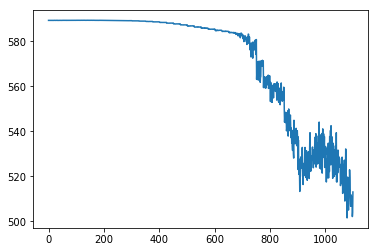

In [20]:
# original network
plt.plot(losses)

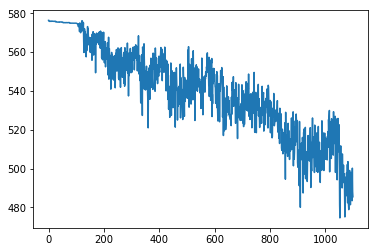

In [99]:
# refactored network
plt.plot(losses)

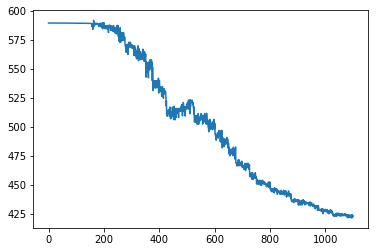

In [150]:
# refactored cnn network with 2,2 filters
plt.plot(losses)

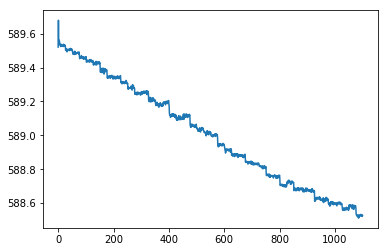

In [104]:
# refactored cnn network with 3,3 filters
plt.plot(losses)

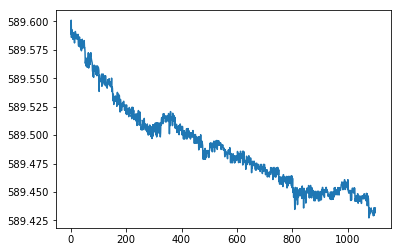

In [156]:
# refactored cnn network with strided convolutions and 2,2 filters
plt.plot(losses)

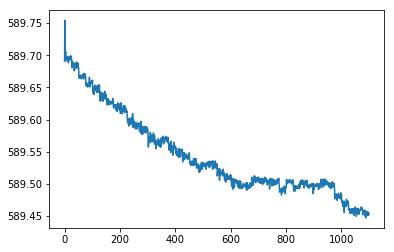

In [162]:
# refactored cnn network with strided convolutions and 3,3 filters
plt.plot(losses)

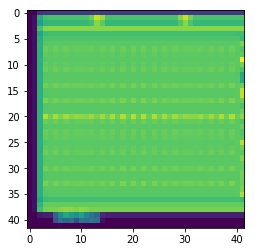

In [105]:
env = gym.make('Freeway-v0') # for this to work you'll need to get the atari rom
plt.imshow(downscale_obs(env.render("rgb_array")))

In [184]:
env = gym.make('Freeway-v0', render_mode='rgb_array') # for this to work you'll need to get the atari rom
env.env.get_action_meanings()

# set model to eval mode
model.eval()

actions = []
done = True
for step in range(10000):
    
    # get state if new game
    if done:
        state1 = preproc_state(env.reset())
    
    # get pred
    pred = model(state1)
    
    # get action from pred
    if np.random.rand(1) < eps_min:
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.detach().numpy(),support).item()
    actions.append(action)
    
    # update env from action
    state2, reward, done, info = env.step(action)
    state2 = preproc_state(state2)
    state1 = state2

    env.render()

env.close()
# print(actions)

## Calculating the expected value from the probabilities and the outcomes is mathematically equivalent to taking the mean of the rewards
- this means that while we've technically built a distributional model, we're just using the mean from it anyway
- it appears that this shouldn't be any better than a vanilla non-distributional DQN, however the magic here is in the loss function, not the action selection (which again is done effectively the same way, by taking the mean)
- the loss is the cross-entropy loss between the predicted and real distribution of rewards, which is more expressive than the the normal DQN loss (Huber or MSE)


In [120]:
probs = np.array([0.6, 0.1, 0.1, 0.1, 0.1])
outcomes = np.array([18, 21, 17, 17, 21])
expected_value = 0.0
for i in range(probs.shape[0]):
    expected_value += probs[i] * outcomes[i]

print("expected value calculation:", expected_value)

# expected_value = probs @ outcomes
# print(expected_value)

counts = np.array([6, 1, 1, 1, 1])
outcomes = np.array([18, 21, 17, 17, 21])
total = 0.0
for i in range(counts.shape[0]):
    total += counts[i] * outcomes[i]

print("mean of outcomes with the same distribution:", total/sum(counts))

expected value calculation: 18.4
mean of outcomes with the same distribution: 18.4


## CNN DQN with variance-aware policy (expectation = expectation / variance)

In [164]:
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
model = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, kernel_size=(2, 2), stride=1, padding='same'),
        torch.nn.SELU(),
        torch.nn.Conv2d(32, 32, kernel_size=(2, 2), stride=1, padding='same'),
        torch.nn.SELU(),
        torch.nn.Conv2d(32, 32, kernel_size=(2, 2), stride=1, padding='same'),
        torch.nn.SELU(),
        torch.nn.Conv2d(32, 51*3, kernel_size=(2, 2), stride=1, padding='same'),
        torch.nn.SELU(),
        torch.nn.AdaptiveAvgPool2d((1)),
        torch.nn.Flatten(start_dim=1),
        torch.nn.ReLU(),
        Reshape(-1, 3, 51), # dim 2 needs to match nsup. # batch, aspace, nsup
        # this is done this way so that you can create a distribution of values for each action
        torch.nn.Softmax(dim=2),
)
 
model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [165]:
# cross-entry loss between predicted and target distributions
def lossfn(x,y):#A
    loss = torch.Tensor([0.])
    loss.requires_grad=True
    for i in range(x.shape[0]): #B 
        loss_ = -1 *  torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0) #C
        loss = loss + loss_
    return loss

def update_dist(r,support,probs,lim=(-10.,10.),gamma=0.8):
#     print('probs', probs)
    nsup = probs.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.) #A
    bj = np.round((r-vmin)/dz) #B
    bj = int(np.clip(bj,0,nsup-1)) #C
    m = probs.clone()
    j = 1
    for i in range(bj,1,-1): #D
        m[i] += np.power(gamma,j) * m[i-1]
        j += 1
    j = 1
    for i in range(bj,nsup-1,1): #E
        m[i] += np.power(gamma,j) * m[i+1]
        j += 1
    m /= m.sum() #F
    return m

def get_target_dist(dist_batch,action_batch,reward_batch,support,lim=(-10,10),gamma=0.8):
    nsup = support.shape[0]
#     print('nsup',nsup)
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    target_dist_batch = dist_batch.clone()
    for i in range(dist_batch.shape[0]): #A
        dist_full = dist_batch[i]
        action = int(action_batch[i].item())
        dist = dist_full[action]
        r = reward_batch[i]
        if r != -1: #B
            target_dist = torch.zeros(nsup)
            bj = np.round((r-vmin)/dz)
            bj = int(np.clip(bj,0,nsup-1))
            target_dist[bj] = 1.
        else: #C
            target_dist = update_dist(r,support,dist,lim=lim,gamma=gamma)
        target_dist_batch[i,action,:] = target_dist #D
        
    return target_dist_batch

def preproc_state(state):
#     p_state = torch.from_numpy(state).float()
    p_state = torch.from_numpy(downscale_obs(state, to_gray=False)).unsqueeze(dim=0).float()
#     p_state = torch.from_numpy(state).unsqueeze(dim=0).float()
    p_state = torch.nn.functional.normalize(p_state) #A
    p_state = rearrange(p_state, 'b h w c -> b c h w')
    return p_state

# Listing 8.2
def downscale_obs(obs, new_size=(42, 42), to_gray=True):
    if to_gray:
        return resize(obs, new_size, anti_aliasing=True).max(axis=2)  # B
    else:
        return resize(obs, new_size, anti_aliasing=True)
    
# Listing 8.4
def prepare_state(state):  # A
    return torch.from_numpy(downscale_obs(state, to_gray=True)).float().unsqueeze(dim=0)

def get_action(dist,support):
    """
    This is a bit hacky, but I'm introducing the concept of variance into the action selection
    by dividing the expectations by the variance. This should weight expectations by how variable they are.
    I could subtract the variance instead to penalize that way.
    """
    actions = []
    for b in range(dist.shape[0]): #B
#         print(dist.shape)
#         print(support.shape)
        expectations = [support @ dist[b,a,:] for a in range(dist.shape[1])] #C
#         print([dist[b,a,:].detach().numpy() for a in range(dist.shape[1])])
        distributions = [dist[b,a,:].detach().numpy() for a in range(dist.shape[1])]
        variances = [np.var(x) for x in distributions]
        expectations = np.array(expectations) / np.array(variances)
#         expectations = [support @ dist[b,a,:] for a in range(dist.shape[1])] #C
#         print([dist[b,:,:] for b in range(dist.shape[0])])
        
#         print(expectations)
#         print(variances)
        
#         print(expectations)
        action = int(np.argmax(expectations)) #D
        actions.append(action)
    actions = torch.Tensor(actions).int()
#     print(actions.shape)
    return actions

In [166]:
# load screen version of Freeway
env = gym.make('Freeway-v0') # for this to work you'll need to get the atari rom
aspace = 3
env.env.get_action_meanings()

vmin,vmax = -10,10
replay_size = 200
batch_size = 50
nsup = 51
dz = (vmax - vmin) / (nsup-1)
support = torch.linspace(vmin,vmax,nsup)

replay = deque(maxlen=replay_size) #A
lr = 0.0001 #B 
gamma = 0.1 #C 
epochs = 1300
eps = 0.20 #D starting epsilon for epsilon-greedy policy
eps_min = 0.05 #E ending epsilon
priority_level = 5 #F 
update_freq = 25 #G 

losses = []
cum_rewards = [] #K 
renders = []
state = preproc_state(env.reset())

In [167]:
for i in trange(epochs):
#     print(state.shape)
    pred = model(state)
    if i < replay_size or np.random.rand(1) < eps: #A
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.detach(),support).item()
    state2, reward, done, info = env.step(action) #B
    state2 = preproc_state(state2)
    if reward == 1: cum_rewards.append(1) 
    reward = 10 if reward == 1 else reward #C
    reward = -10 if done else reward #D
    reward = -1 if reward == 0 else reward #E
    exp = (state,action,reward,state2) #F
    replay.append(exp) #G
    
    if reward == 10: #H
        for e in range(priority_level):
            replay.append(exp)
            
    shuffle(replay)
    state = state2

    if len(replay) == replay_size: #I
        indx = np.random.randint(low=0,high=len(replay),size=batch_size)
        exps = [replay[j] for j in indx]
        state_batch = torch.stack([ex[0] for ex in exps],dim=1).squeeze()
        action_batch = torch.Tensor([ex[1] for ex in exps])
        reward_batch = torch.Tensor([ex[2] for ex in exps])
        state2_batch = torch.stack([ex[3] for ex in exps],dim=1).squeeze()  
        
        pred_batch = model(state_batch.detach())
        pred2_batch = model2(state2_batch.detach())

        target_dist = get_target_dist(pred2_batch,action_batch,reward_batch, 
                                      support, lim=(vmin,vmax),gamma=gamma)
        loss = lossfn(pred_batch,target_dist.detach())
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    
    if i % update_freq == 0:
        model2.load_state_dict(model.state_dict())
        
    if i > 100 and eps > eps_min: #L
        dec = 1./np.log2(i)
        dec /= 1e3
        eps -= dec
    
    if done: #M
        state = preproc_state(env.reset())
        done = False

  0%|          | 0/1300 [00:00<?, ?it/s]

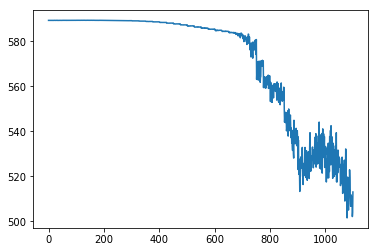

In [20]:
# original network
plt.plot(losses)

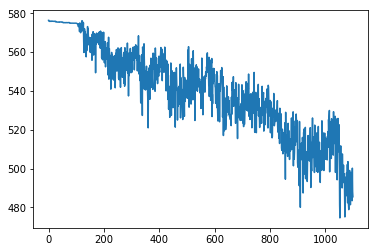

In [99]:
# refactored network
plt.plot(losses)

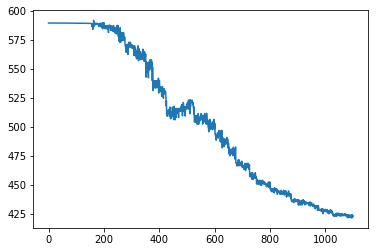

In [150]:
# refactored cnn network with 2,2 filters
plt.plot(losses)

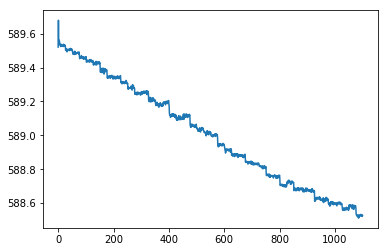

In [104]:
# refactored cnn network with 3,3 filters
plt.plot(losses)

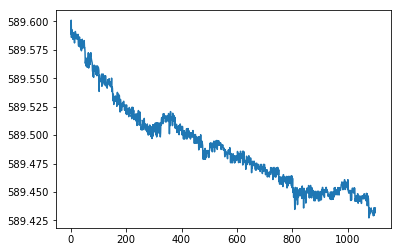

In [156]:
# refactored cnn network with strided convolutions and 2,2 filters
plt.plot(losses)

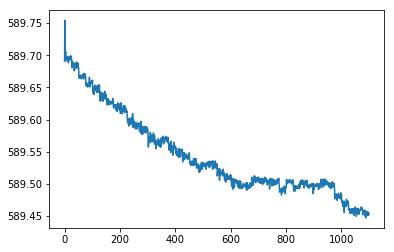

In [162]:
# refactored cnn network with strided convolutions and 3,3 filters
plt.plot(losses)

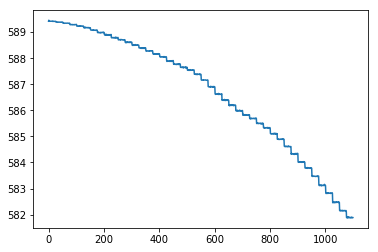

In [168]:
# refactored cnn network with 2,2 filters and variance-aware policy (division)
plt.plot(losses)

In [112]:
env = gym.make('Freeway-v0', render_mode='rgb_array') # for this to work you'll need to get the atari rom
env.env.get_action_meanings()

# set model to eval mode
model.eval()

actions = []
done = True
for step in range(10000):
    
    # get state if new game
    if done:
        state1 = preproc_state(env.reset())
    
    # get pred
    pred = model(state1)
    
    # get action from pred
    if np.random.rand(1) < eps_min:
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.detach(),support).item()
    actions.append(action)
    
    # update env from action
    state2, reward, done, info = env.step(action)
    state2 = preproc_state(state2)
    state1 = state2

    env.render()

env.close()
# print(actions)

## CNN DQN with variance-aware policy (subtracting variance from expectation)

In [169]:
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
model = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, kernel_size=(2, 2), stride=1, padding='same'),
        torch.nn.SELU(),
        torch.nn.Conv2d(32, 32, kernel_size=(2, 2), stride=1, padding='same'),
        torch.nn.SELU(),
        torch.nn.Conv2d(32, 32, kernel_size=(2, 2), stride=1, padding='same'),
        torch.nn.SELU(),
        torch.nn.Conv2d(32, 51*3, kernel_size=(2, 2), stride=1, padding='same'),
        torch.nn.SELU(),
        torch.nn.AdaptiveAvgPool2d((1)),
        torch.nn.Flatten(start_dim=1),
        torch.nn.ReLU(),
        Reshape(-1, 3, 51), # dim 2 needs to match nsup. # batch, aspace, nsup
        # this is done this way so that you can create a distribution of values for each action
        torch.nn.Softmax(dim=2),
)
 
model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [170]:
# cross-entry loss between predicted and target distributions
def lossfn(x,y):#A
    loss = torch.Tensor([0.])
    loss.requires_grad=True
    for i in range(x.shape[0]): #B 
        loss_ = -1 *  torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0) #C
        loss = loss + loss_
    return loss

def update_dist(r,support,probs,lim=(-10.,10.),gamma=0.8):
#     print('probs', probs)
    nsup = probs.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.) #A
    bj = np.round((r-vmin)/dz) #B
    bj = int(np.clip(bj,0,nsup-1)) #C
    m = probs.clone()
    j = 1
    for i in range(bj,1,-1): #D
        m[i] += np.power(gamma,j) * m[i-1]
        j += 1
    j = 1
    for i in range(bj,nsup-1,1): #E
        m[i] += np.power(gamma,j) * m[i+1]
        j += 1
    m /= m.sum() #F
    return m

def get_target_dist(dist_batch,action_batch,reward_batch,support,lim=(-10,10),gamma=0.8):
    nsup = support.shape[0]
#     print('nsup',nsup)
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    target_dist_batch = dist_batch.clone()
    for i in range(dist_batch.shape[0]): #A
        dist_full = dist_batch[i]
        action = int(action_batch[i].item())
        dist = dist_full[action]
        r = reward_batch[i]
        if r != -1: #B
            target_dist = torch.zeros(nsup)
            bj = np.round((r-vmin)/dz)
            bj = int(np.clip(bj,0,nsup-1))
            target_dist[bj] = 1.
        else: #C
            target_dist = update_dist(r,support,dist,lim=lim,gamma=gamma)
        target_dist_batch[i,action,:] = target_dist #D
        
    return target_dist_batch

def preproc_state(state):
#     p_state = torch.from_numpy(state).float()
    p_state = torch.from_numpy(downscale_obs(state, to_gray=False)).unsqueeze(dim=0).float()
#     p_state = torch.from_numpy(state).unsqueeze(dim=0).float()
    p_state = torch.nn.functional.normalize(p_state) #A
    p_state = rearrange(p_state, 'b h w c -> b c h w')
    return p_state

# Listing 8.2
def downscale_obs(obs, new_size=(42, 42), to_gray=True):
    if to_gray:
        return resize(obs, new_size, anti_aliasing=True).max(axis=2)  # B
    else:
        return resize(obs, new_size, anti_aliasing=True)
    
# Listing 8.4
def prepare_state(state):  # A
    return torch.from_numpy(downscale_obs(state, to_gray=True)).float().unsqueeze(dim=0)

def get_action(dist,support):
    """
    This is a bit hacky, but I'm introducing the concept of variance into the action selection
    by subtracting the expectations by the variance.
    """
    actions = []
    for b in range(dist.shape[0]): #B
#         print(dist.shape)
#         print(support.shape)
        expectations = [support @ dist[b,a,:] for a in range(dist.shape[1])] #C
#         print([dist[b,a,:].detach().numpy() for a in range(dist.shape[1])])
        distributions = [dist[b,a,:].detach().numpy() for a in range(dist.shape[1])]
        variances = [np.var(x) for x in distributions]
        expectations = np.array(expectations) - np.array(variances)
#         expectations = [support @ dist[b,a,:] for a in range(dist.shape[1])] #C
#         print([dist[b,:,:] for b in range(dist.shape[0])])
        
#         print(expectations)
#         print(variances)
        
#         print(expectations)
        action = int(np.argmax(expectations)) #D
        actions.append(action)
    actions = torch.Tensor(actions).int()
#     print(actions.shape)
    return actions

In [171]:
# load screen version of Freeway
env = gym.make('Freeway-v0') # for this to work you'll need to get the atari rom
aspace = 3
env.env.get_action_meanings()

vmin,vmax = -10,10
replay_size = 200
batch_size = 50
nsup = 51
dz = (vmax - vmin) / (nsup-1)
support = torch.linspace(vmin,vmax,nsup)

replay = deque(maxlen=replay_size) #A
lr = 0.0001 #B 
gamma = 0.1 #C 
epochs = 1300
eps = 0.20 #D starting epsilon for epsilon-greedy policy
eps_min = 0.05 #E ending epsilon
priority_level = 5 #F 
update_freq = 25 #G 

losses = []
cum_rewards = [] #K 
renders = []
state = preproc_state(env.reset())

In [172]:
for i in trange(epochs):
#     print(state.shape)
    pred = model(state)
    if i < replay_size or np.random.rand(1) < eps: #A
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.detach(),support).item()
    state2, reward, done, info = env.step(action) #B
    state2 = preproc_state(state2)
    if reward == 1: cum_rewards.append(1) 
    reward = 10 if reward == 1 else reward #C
    reward = -10 if done else reward #D
    reward = -1 if reward == 0 else reward #E
    exp = (state,action,reward,state2) #F
    replay.append(exp) #G
    
    if reward == 10: #H
        for e in range(priority_level):
            replay.append(exp)
            
    shuffle(replay)
    state = state2

    if len(replay) == replay_size: #I
        indx = np.random.randint(low=0,high=len(replay),size=batch_size)
        exps = [replay[j] for j in indx]
        state_batch = torch.stack([ex[0] for ex in exps],dim=1).squeeze()
        action_batch = torch.Tensor([ex[1] for ex in exps])
        reward_batch = torch.Tensor([ex[2] for ex in exps])
        state2_batch = torch.stack([ex[3] for ex in exps],dim=1).squeeze()  
        
        pred_batch = model(state_batch.detach())
        pred2_batch = model2(state2_batch.detach())

        target_dist = get_target_dist(pred2_batch,action_batch,reward_batch, 
                                      support, lim=(vmin,vmax),gamma=gamma)
        loss = lossfn(pred_batch,target_dist.detach())
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    
    if i % update_freq == 0:
        model2.load_state_dict(model.state_dict())
        
    if i > 100 and eps > eps_min: #L
        dec = 1./np.log2(i)
        dec /= 1e3
        eps -= dec
    
    if done: #M
        state = preproc_state(env.reset())
        done = False

  0%|          | 0/1300 [00:00<?, ?it/s]

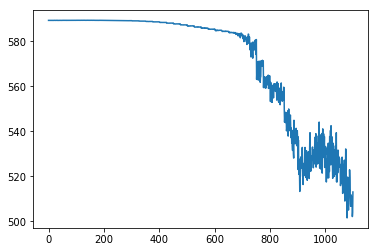

In [20]:
# original network
plt.plot(losses)

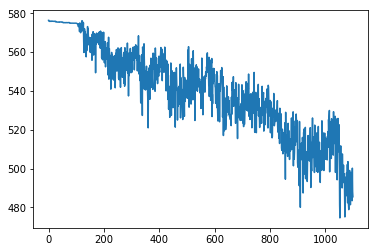

In [99]:
# refactored network
plt.plot(losses)

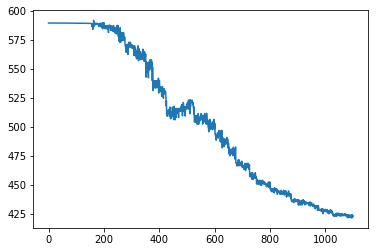

In [150]:
# refactored cnn network with 2,2 filters
plt.plot(losses)

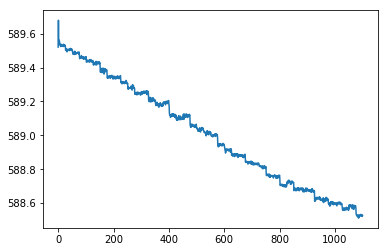

In [104]:
# refactored cnn network with 3,3 filters
plt.plot(losses)

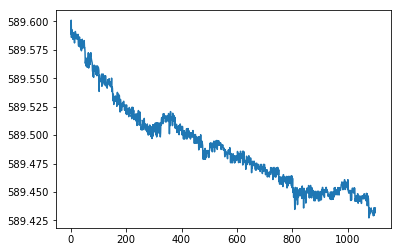

In [156]:
# refactored cnn network with strided convolutions and 2,2 filters
plt.plot(losses)

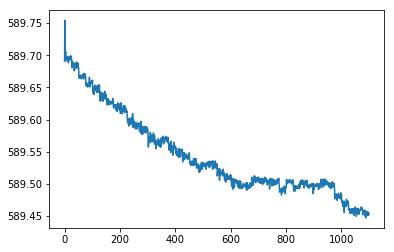

In [162]:
# refactored cnn network with strided convolutions and 3,3 filters
plt.plot(losses)

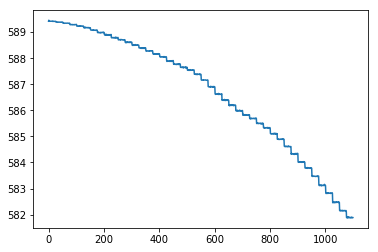

In [168]:
# refactored cnn network with 2,2 filters and variance-aware policy (division)
plt.plot(losses)

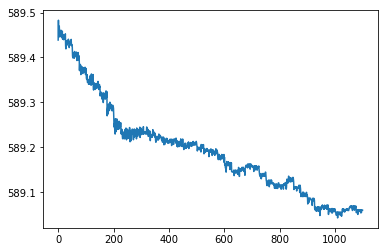

In [173]:
# refactored cnn network with 2,2 filters and variance-aware policy (subtraction)
plt.plot(losses)

In [118]:
env = gym.make('Freeway-v0', render_mode='rgb_array') # for this to work you'll need to get the atari rom
env.env.get_action_meanings()

# set model to eval mode
model.eval()

actions = []
done = True
for step in range(10000):
    
    # get state if new game
    if done:
        state1 = preproc_state(env.reset())
    
    # get pred
    pred = model(state1)
    
    # get action from pred
    if np.random.rand(1) < eps_min:
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.detach(),support).item()
    actions.append(action)
    
    # update env from action
    state2, reward, done, info = env.step(action)
    state2 = preproc_state(state2)
    state1 = state2

    env.render()

env.close()
# print(actions)

## CNN DQN with variance-aware policy (take the most rewarding action rather than the most rewarding action on average)

In [174]:
class Reshape(torch.nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)
    
model = torch.nn.Sequential(
        torch.nn.Conv2d(3, 32, kernel_size=(2, 2), stride=1, padding='same'),
        torch.nn.SELU(),
        torch.nn.Conv2d(32, 32, kernel_size=(2, 2), stride=1, padding='same'),
        torch.nn.SELU(),
        torch.nn.Conv2d(32, 32, kernel_size=(2, 2), stride=1, padding='same'),
        torch.nn.SELU(),
        torch.nn.Conv2d(32, 51*3, kernel_size=(2, 2), stride=1, padding='same'),
        torch.nn.SELU(),
        torch.nn.AdaptiveAvgPool2d((1)),
        torch.nn.Flatten(start_dim=1),
        torch.nn.ReLU(),
        Reshape(-1, 3, 51), # dim 2 needs to match nsup. # batch, aspace, nsup
        # this is done this way so that you can create a distribution of values for each action
        torch.nn.Softmax(dim=2),
)
 
model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [175]:
# cross-entry loss between predicted and target distributions
def lossfn(x,y):#A
    loss = torch.Tensor([0.])
    loss.requires_grad=True
    for i in range(x.shape[0]): #B 
        loss_ = -1 *  torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0) #C
        loss = loss + loss_
    return loss

def update_dist(r,support,probs,lim=(-10.,10.),gamma=0.8):
#     print('probs', probs)
    nsup = probs.shape[0]
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.) #A
    bj = np.round((r-vmin)/dz) #B
    bj = int(np.clip(bj,0,nsup-1)) #C
    m = probs.clone()
    j = 1
    for i in range(bj,1,-1): #D
        m[i] += np.power(gamma,j) * m[i-1]
        j += 1
    j = 1
    for i in range(bj,nsup-1,1): #E
        m[i] += np.power(gamma,j) * m[i+1]
        j += 1
    m /= m.sum() #F
    return m

def get_target_dist(dist_batch,action_batch,reward_batch,support,lim=(-10,10),gamma=0.8):
    nsup = support.shape[0]
#     print('nsup',nsup)
    vmin,vmax = lim[0],lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    target_dist_batch = dist_batch.clone()
    for i in range(dist_batch.shape[0]): #A
        dist_full = dist_batch[i]
        action = int(action_batch[i].item())
        dist = dist_full[action]
        r = reward_batch[i]
        if r != -1: #B
            target_dist = torch.zeros(nsup)
            bj = np.round((r-vmin)/dz)
            bj = int(np.clip(bj,0,nsup-1))
            target_dist[bj] = 1.
        else: #C
            target_dist = update_dist(r,support,dist,lim=lim,gamma=gamma)
        target_dist_batch[i,action,:] = target_dist #D
        
    return target_dist_batch

def preproc_state(state):
#     p_state = torch.from_numpy(state).float()
    p_state = torch.from_numpy(downscale_obs(state, to_gray=False)).unsqueeze(dim=0).float()
#     p_state = torch.from_numpy(state).unsqueeze(dim=0).float()
    p_state = torch.nn.functional.normalize(p_state) #A
    p_state = rearrange(p_state, 'b h w c -> b c h w')
    return p_state

# Listing 8.2
def downscale_obs(obs, new_size=(42, 42), to_gray=True):
    if to_gray:
        return resize(obs, new_size, anti_aliasing=True).max(axis=2)  # B
    else:
        return resize(obs, new_size, anti_aliasing=True)
    
# Listing 8.4
def prepare_state(state):  # A
    return torch.from_numpy(downscale_obs(state, to_gray=True)).float().unsqueeze(dim=0)

def get_action(dist,support):
    """
    Take the Hadamard product of the support and the distribution and take the max of that to get
    the highest predicted reward for each action.
    
    This is a bit hacky, but I'm introducing the concept of variance into the action selection
    by dividing the expectations by the variance.
    """
    actions = []
    for b in range(dist.shape[0]): #B
        expectations = np.array([np.max(np.array(np.multiply(support, dist[b,a,:].detach().numpy()))) for a in range(dist.shape[1])])
        distributions = [dist[b,a,:].detach().numpy() for a in range(dist.shape[1])]
        variances = [np.var(x) for x in distributions]
        expectations = np.array(expectations) / np.array(variances)
        action = int(np.argmax(expectations)) #D
        actions.append(action)
    actions = torch.Tensor(actions).int()
    return actions

In [176]:
# load screen version of Freeway
env = gym.make('Freeway-v0') # for this to work you'll need to get the atari rom
aspace = 3
env.env.get_action_meanings()

vmin,vmax = -10,10
replay_size = 200
batch_size = 50
nsup = 51
dz = (vmax - vmin) / (nsup-1)
support = torch.linspace(vmin,vmax,nsup)

replay = deque(maxlen=replay_size) #A
lr = 0.0001 #B 
gamma = 0.1 #C 
epochs = 1300
eps = 0.20 #D starting epsilon for epsilon-greedy policy
eps_min = 0.05 #E ending epsilon
priority_level = 5 #F 
update_freq = 25 #G 

losses = []
cum_rewards = [] #K 
renders = []
state = preproc_state(env.reset())

In [177]:
for i in trange(epochs):
#     print(state.shape)
    pred = model(state)
    if i < replay_size or np.random.rand(1) < eps: #A
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.detach(),support).item()
    state2, reward, done, info = env.step(action) #B
    state2 = preproc_state(state2)
    if reward == 1: cum_rewards.append(1) 
    reward = 10 if reward == 1 else reward #C
    reward = -10 if done else reward #D
    reward = -1 if reward == 0 else reward #E
    exp = (state,action,reward,state2) #F
    replay.append(exp) #G
    
    if reward == 10: #H
        for e in range(priority_level):
            replay.append(exp)
            
    shuffle(replay)
    state = state2

    if len(replay) == replay_size: #I
        indx = np.random.randint(low=0,high=len(replay),size=batch_size)
        exps = [replay[j] for j in indx]
        state_batch = torch.stack([ex[0] for ex in exps],dim=1).squeeze()
        action_batch = torch.Tensor([ex[1] for ex in exps])
        reward_batch = torch.Tensor([ex[2] for ex in exps])
        state2_batch = torch.stack([ex[3] for ex in exps],dim=1).squeeze()  
        
        pred_batch = model(state_batch.detach())
        pred2_batch = model2(state2_batch.detach())

        target_dist = get_target_dist(pred2_batch,action_batch,reward_batch, 
                                      support, lim=(vmin,vmax),gamma=gamma)
        loss = lossfn(pred_batch,target_dist.detach())
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    
    if i % update_freq == 0:
        model2.load_state_dict(model.state_dict())
        
    if i > 100 and eps > eps_min: #L
        dec = 1./np.log2(i)
        dec /= 1e3
        eps -= dec
    
    if done: #M
        state = preproc_state(env.reset())
        done = False

  0%|          | 0/1300 [00:00<?, ?it/s]

<ipython-input-175-3373bfa309f3>:83: RuntimeWarning: divide by zero encountered in true_divide
  expectations = np.array(expectations) / np.array(variances)


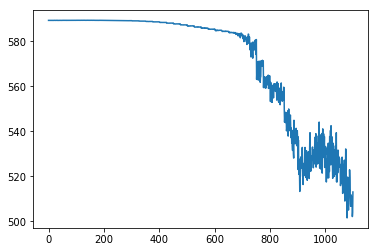

In [20]:
# original network
plt.plot(losses)

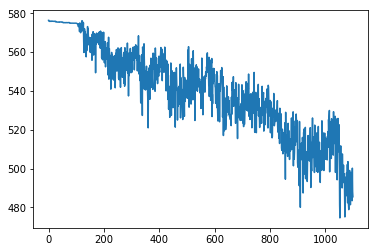

In [99]:
# refactored network
plt.plot(losses)

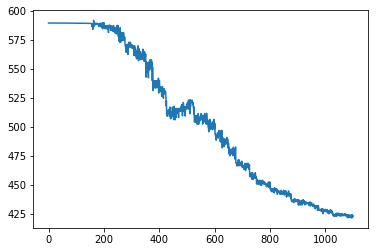

In [150]:
# refactored cnn network with 2,2 filters
plt.plot(losses)

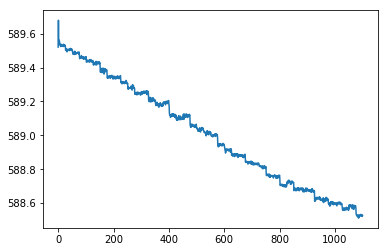

In [104]:
# refactored cnn network with 3,3 filters
plt.plot(losses)

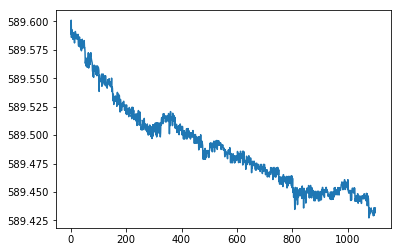

In [156]:
# refactored cnn network with strided convolutions and 2,2 filters
plt.plot(losses)

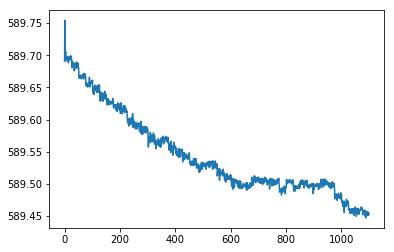

In [162]:
# refactored cnn network with strided convolutions and 3,3 filters
plt.plot(losses)

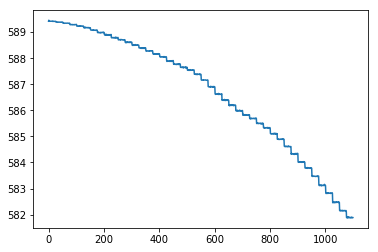

In [168]:
# refactored cnn network with 2,2 filters and variance-aware policy (division)
plt.plot(losses)

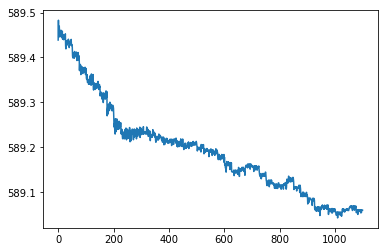

In [173]:
# refactored cnn network with 2,2 filters and variance-aware policy (subtraction)
plt.plot(losses)

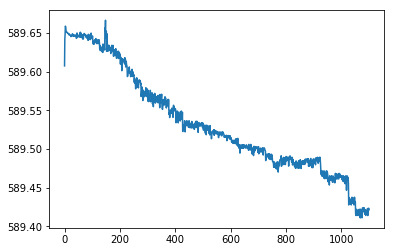

In [178]:
# refactored cnn network with 2,2 filters and variance-aware policy (division) taking
# the most rewarding possible action divided by the variance of that action
plt.plot(losses)

In [179]:
env = gym.make('Freeway-v0', render_mode='rgb_array') # for this to work you'll need to get the atari rom
env.env.get_action_meanings()

# set model to eval mode
model.eval()

actions = []
done = True
for step in range(10000):
    
    # get state if new game
    if done:
        state1 = preproc_state(env.reset())
    
    # get pred
    pred = model(state1)
    
    # get action from pred
    if np.random.rand(1) < eps_min:
        action = np.random.randint(aspace)
    else:
        action = get_action(pred.detach(),support).item()
    actions.append(action)
    
    # update env from action
    state2, reward, done, info = env.step(action)
    state2 = preproc_state(state2)
    state1 = state2

    env.render()

env.close()
# print(actions)

<ipython-input-175-3373bfa309f3>:83: RuntimeWarning: divide by zero encountered in true_divide
  expectations = np.array(expectations) / np.array(variances)
